In [1]:
student_id =  "98101771"
student_name = "Morteza Seyedi"

print("your student id:", student_id)
print("your name:", student_name)

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize, Lambda
from torch import nn
from tqdm import trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

your student id: 98101771
your name: Morteza Seyedi


model :

In [2]:
class Forward_Forward_1(nn.Module):
    def __init__(self):
        super(Forward_Forward_1, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(28*28, 1000),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.fc1(x)
        return x
    
class Forward_Forward_2(nn.Module):
    def __init__(self):
        super(Forward_Forward_2, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 500),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.fc1(x)
        return x

Supervised :

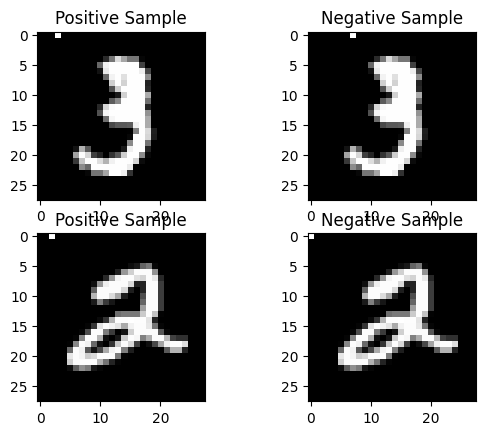

In [3]:
# preprocessing
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Lambda(lambda x: torch.flatten(x))
])

pos_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms
)

neg_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms
)

pos_train_data.data[:, 0, :10] = 255 * torch.nn.functional.one_hot(pos_train_data.targets)
neg_y_one_hot = torch.nn.functional.one_hot(neg_train_data.targets)
for j in range(len(neg_y_one_hot)):
    random_index = torch.randint(0, 10, (1,))
    one_position = torch.argmax(neg_y_one_hot[j])
    while random_index == one_position:
        random_index = torch.randint(0, 10, (1,))
    neg_y_one_hot[j][random_index] = 255
    neg_y_one_hot[j][one_position] = 0

neg_train_data.data[:, 0, :10] = neg_y_one_hot

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(pos_train_data.data[10], cmap='gray')
axs[0, 0].set_title('Positive Sample')
axs[0, 1].imshow(neg_train_data.data[10], cmap='gray')
axs[0, 1].set_title('Negative Sample')
axs[1, 0].imshow(pos_train_data.data[5], cmap='gray')
axs[1, 0].set_title('Positive Sample')
axs[1, 1].imshow(neg_train_data.data[5], cmap='gray')
axs[1, 1].set_title('Negative Sample')
plt.show()

In [4]:
# training one layer of forward forward
ff_layer1 = Forward_Forward_1().to(device)
ff_layer2 = Forward_Forward_2().to(device)

threshold = 2
batch_size = 1000
epochs = 20
optimizer1 = torch.optim.Adam(ff_layer1.parameters(), lr=0.003)
optimizer2 = torch.optim.Adam(ff_layer2.parameters(), lr=0.003)
pos_train_loader = DataLoader(pos_train_data, batch_size=batch_size, shuffle=False)
neg_train_loader = DataLoader(neg_train_data, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    for i, (pos_data, neg_data) in enumerate(zip(pos_train_loader, neg_train_loader)):
        pos_data = pos_data[0].to(device)
        neg_data = neg_data[0].to(device)
        
        # first layer
        optimizer1.zero_grad()
        layer1_output_pos = ff_layer1(pos_data)
        layer1_output_neg = ff_layer1(neg_data)

        G_pos = layer1_output_pos.pow(2).mean(dim = 1)
        G_neg = layer1_output_neg.pow(2).mean(dim = 1)

        loss1 = torch.log(1 + torch.exp(torch.cat([threshold - G_pos, G_neg - threshold]))).mean()
        loss1.backward()
        optimizer1.step()

        # second layer
        layer1_output_pos = layer1_output_pos.detach()
        layer1_output_neg = layer1_output_neg.detach()
        layer1_output_pos = layer1_output_pos / (layer1_output_pos.norm(2, 1, keepdim=True) + 1e-3)
        layer1_output_neg = layer1_output_neg / (layer1_output_neg.norm(2, 1, keepdim=True) + 1e-3)
        optimizer2.zero_grad()
        layer2_output_pos = ff_layer2(layer1_output_pos)
        layer2_output_neg = ff_layer2(layer1_output_neg)

        G_pos = layer2_output_pos.pow(2).mean(dim = 1)
        G_neg = layer2_output_neg.pow(2).mean(dim = 1)

        loss2 = torch.log(1 + torch.exp(torch.cat([threshold - G_pos, G_neg - threshold]))).mean()
        loss2.backward()
        optimizer2.step()
    
    print(f'epoch: {epoch}, loss1: {loss1.item()}, loss2: {loss2.item()}')

epoch: 0, loss1: 0.5517460107803345, loss2: 0.7390272617340088
epoch: 1, loss1: 0.4158814251422882, loss2: 0.6874046921730042
epoch: 2, loss1: 0.34883376955986023, loss2: 0.6038055419921875
epoch: 3, loss1: 0.31009411811828613, loss2: 0.543739378452301
epoch: 4, loss1: 0.28264179825782776, loss2: 0.49653106927871704
epoch: 5, loss1: 0.26036059856414795, loss2: 0.4538034200668335
epoch: 6, loss1: 0.2424999475479126, loss2: 0.41917139291763306
epoch: 7, loss1: 0.22711019217967987, loss2: 0.39234545826911926
epoch: 8, loss1: 0.21348026394844055, loss2: 0.37141579389572144
epoch: 9, loss1: 0.2017166167497635, loss2: 0.3528664708137512
epoch: 10, loss1: 0.19130003452301025, loss2: 0.3358602225780487
epoch: 11, loss1: 0.1819656789302826, loss2: 0.3221755623817444
epoch: 12, loss1: 0.17357392609119415, loss2: 0.3117414116859436
epoch: 13, loss1: 0.16600151360034943, loss2: 0.3033792972564697
epoch: 14, loss1: 0.1591910421848297, loss2: 0.2959725260734558
epoch: 15, loss1: 0.1530901938676834, 

In [6]:
# making a full classifier with the forward forward

for param in ff_layer1.parameters():
    param.requires_grad = False
for param in ff_layer2.parameters():
    param.requires_grad = False

class Forward_Forward(nn.Module):
    def __init__(self):
        super(Forward_Forward, self).__init__()
        self.forward_forward_1 = ff_layer1
        self.forward_forward_2 = ff_layer2
    def forward(self, x):
        x = self.forward_forward_1(x)
        x = self.forward_forward_2(x)
        return x

model2 = Forward_Forward().to(device)

# test the model on the test data
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms 
)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data_0 = data.clone()
        data_0.data[:,0] = 2.821
        data_0 = data_0.to(device)
        data_1 = data.clone()
        data_1.data[:,1] = 2.821
        data_1 = data_1.to(device)
        data_2 = data.clone()
        data_2.data[:,2] = 2.821
        data_2 = data_2.to(device)
        data_3 = data.clone()
        data_3.data[:,3] = 2.821
        data_3 = data_3.to(device)
        data_4 = data.clone()
        data_4.data[:,4] = 2.821
        data_4 = data_4.to(device)
        data_5 = data.clone()
        data_5.data[:,5] = 2.821
        data_5 = data_5.to(device)
        data_6 = data.clone()
        data_6.data[:,6] = 2.821
        data_6 = data_6.to(device)
        data_7 = data.clone()
        data_7.data[:,7] = 2.821
        data_7 = data_7.to(device)
        data_8 = data.clone()
        data_8.data[:,8] = 2.821
        data_8 = data_8.to(device)
        data_9 = data.clone()
        data_9.data[:,9] = 2.821
        data_9 = data_9.to(device)

        goodness_0 = model2(data_0).pow(2).mean(dim = 1)
        goodness_1 = model2(data_1).pow(2).mean(dim = 1)
        goodness_2 = model2(data_2).pow(2).mean(dim = 1)
        goodness_3 = model2(data_3).pow(2).mean(dim = 1)
        goodness_4 = model2(data_4).pow(2).mean(dim = 1)
        goodness_5 = model2(data_5).pow(2).mean(dim = 1)
        goodness_6 = model2(data_6).pow(2).mean(dim = 1)
        goodness_7 = model2(data_7).pow(2).mean(dim = 1)
        goodness_8 = model2(data_8).pow(2).mean(dim = 1)
        goodness_9 = model2(data_9).pow(2).mean(dim = 1)
        
        goodness = torch.stack((goodness_0, goodness_1, goodness_2, goodness_3, goodness_4, goodness_5, goodness_6, goodness_7, goodness_8, goodness_9), dim=1)

        target = target.to(device)
        predicted = torch.argmax(goodness, dim=1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'accuracy: {correct / total}')


accuracy: 0.9385


unsupervised :

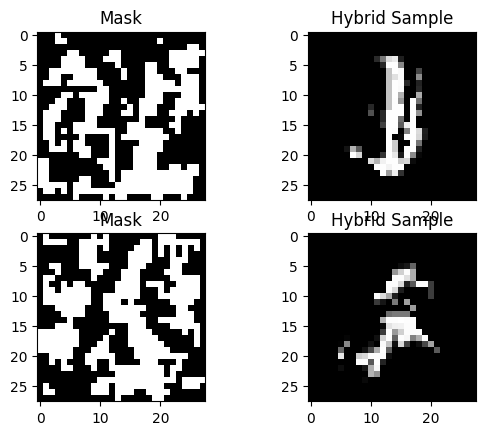

In [7]:
# preprocessing
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Lambda(lambda x: torch.flatten(x))
])

pos_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms 
)

hybrid_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms 
)

mask = torch.randint(0, 2, (len(hybrid_train_data), 1, 28, 28), dtype=torch.long)
mask = torch.nn.functional.conv2d(mask.float(), torch.ones((1, 1, 3, 3)), padding=1)
mask = torch.where(mask > 4, torch.ones_like(mask), torch.zeros_like(mask))
mask_invert = torch.ones_like(mask) - mask
# shuffle the hybrid data
random_index = torch.randperm(len(hybrid_train_data))

for i in range(len(hybrid_train_data)):
    hybrid_train_data.data[i] = pos_train_data.data[i] * mask[i] + hybrid_train_data.data[random_index[i]] * mask_invert[i]

# show the mask and show 2 samples from positive and hybrid datasets
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(mask[10, 0], cmap='gray')
axs[0, 0].set_title('Mask')
axs[0, 1].imshow(hybrid_train_data.data[10], cmap='gray')
axs[0, 1].set_title('Hybrid Sample')
axs[1, 0].imshow(mask[5, 0], cmap='gray')
axs[1, 0].set_title('Mask')
axs[1, 1].imshow(hybrid_train_data.data[5], cmap='gray')
axs[1, 1].set_title('Hybrid Sample')
plt.show()


In [ ]:
# training one layer of forward forward
ff_layer1 = Forward_Forward_1().to(device)
ff_layer2 = Forward_Forward_2().to(device)

threshold = 5
batch_size = 1000
epochs = 40
optimizer1 = torch.optim.Adam(ff_layer1.parameters(), lr=0.05)
optimizer2 = torch.optim.Adam(ff_layer2.parameters(), lr=0.05)
pos_train_loader = DataLoader(pos_train_data, batch_size=batch_size, shuffle=True)
hybrid_train_loader = DataLoader(hybrid_train_data, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for i, (pos_data, hybrid_data) in enumerate(zip(pos_train_loader, hybrid_train_loader)):
        pos_data = pos_data[0].to(device)
        hybrid_data = hybrid_data[0].to(device)
        # first layer
        optimizer1.zero_grad()
        layer1_output_pos = ff_layer1(pos_data)
        layer1_output_hybrid = ff_layer1(hybrid_data)
        G_pos = layer1_output_pos.pow(2).mean(dim = 1)
        G_neg = layer1_output_hybrid.pow(2).mean(dim = 1)

        loss1 = torch.log(1 + torch.exp(torch.cat([threshold - G_pos, G_neg - threshold]))).mean()
        loss1.backward()
        optimizer1.step()

        # second layer
        layer1_output_pos = layer1_output_pos.detach()
        layer1_output_hybrid = layer1_output_hybrid.detach()
        layer1_output_pos = layer1_output_pos / (layer1_output_pos.norm(2, 1, keepdim=True) + 1e-3)
        layer1_output_hybrid = layer1_output_hybrid / (layer1_output_hybrid.norm(2, 1, keepdim=True) + 1e-3)
        optimizer2.zero_grad()
        layer2_output_pos = ff_layer2(layer1_output_pos)
        layer2_output_hybrid = ff_layer2(layer1_output_hybrid)

        G_pos = layer2_output_pos.pow(2).mean(dim = 1)
        G_neg = layer2_output_hybrid.pow(2).mean(dim = 1)

        loss2 = torch.log(1 + torch.exp(torch.cat([threshold - G_pos, G_neg - threshold]))).mean()
        loss2.backward()
        optimizer2.step()
    
    print(f'epoch: {epoch}, loss1: {loss1.item()}, loss2: {loss2.item()}')

In [ ]:
# making a full classifier with the forward forward

for param in ff_layer1.parameters():
    param.requires_grad = False
for param in ff_layer2.parameters():
    param.requires_grad = False

class Forward_Forward_complete(nn.Module):
    def __init__(self):
        super(Forward_Forward_complete, self).__init__()
        self.forward_forward_1 = ff_layer1
        self.forward_forward_2 = ff_layer2
        self.fc1 = nn.Sequential(
            nn.Linear(100, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.forward_forward_1(x)
        x = self.forward_forward_2(x)
        x = self.fc1(x)
        return x

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms 
)

model2 = Forward_Forward_complete().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
epochs = 60
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model2(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
    print(f'epoch: {epoch}, loss: {loss.item()}')

# test the model on the test data
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms 
)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model2(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'accuracy: {correct / total}')
